In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from data_preprocessing import *

In [2]:
df = get_item_dataframe(2770)
mktslvr_ts, qty_ts, month_ts = get_timeseries_from_dataframe(df)

In [14]:
train_window = 14
data_normalized = preprocess_timeseries(mktslvr_ts[15:])
# Split Train / Test
test_data_normalized = data_normalized[-len(data_normalized)//10:]
train_data_normalized = data_normalized[: len(data_normalized)//10]
# Convert to Tensors
test_data_normalized = torch.cuda.FloatTensor(test_data_normalized).view(-1)
train_data_normalized = torch.cuda.FloatTensor(train_data_normalized).view(-1)
# Create sequences
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [15]:
cuda = torch.device('cuda')

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size, device=cuda),
                            torch.zeros(1,1,self.hidden_layer_size, device=cuda))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [16]:
model = LSTM().cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Training
epochs = 10

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size, device=cuda),
                        torch.zeros(1, 1, model.hidden_layer_size, device=cuda))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00000078
epoch:   9 loss: 0.0000006715


In [18]:
ts1 = []
ts2 = []
for seq, labels in train_inout_seq:
    y_pred = model(seq)
    ts1.append(y_pred.data.cpu().numpy()[0])
    ts2.append(labels.data.cpu().numpy()[0])

In [19]:
# Prediction with no tutor
test_inputs = train_data_normalized.tolist()[-train_window:]

model.eval()

for i in range(len(test_data_normalized)):
    seq = torch.cuda.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size, device=cuda),
                        torch.zeros(1, 1, model.hidden_layer_size, device=cuda))
        test_inputs.append(model(seq).item())

In [20]:
# Prediction with tutor
test_seqs = create_inout_sequences(test_data_normalized, train_window)
predictions = []
targets = []
model.eval()

for seq, label in test_seqs:
    # seq = torch.cuda.FloatTensor(test_inputs)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size, device=cuda),
                        torch.zeros(1, 1, model.hidden_layer_size, device=cuda))
        predictions.append(model(seq).item())
        targets.append(label.item())

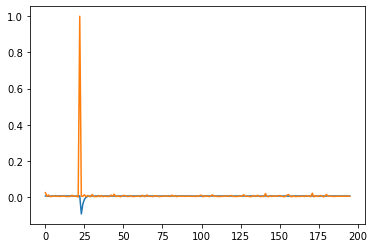

In [21]:
# plt.plot(test_inputs)
plt.plot(predictions)
# plt.plot(test_data_normalized.tolist())
plt.plot(targets)
plt.show()